In [12]:
import pandas as pd
import torch
import numpy as np

# Load your two datasets
df1 = pd.read_csv('/Users/souba636/Documents/vinnova_project_python/data-traces3-NOMS-2025/Blackhole/20/base/base-20-1-dt-1724071478994/features_timeseries_60_sec.csv')
df2 = pd.read_csv('/Users/souba636/Documents/vinnova_project_python/data-traces3-NOMS-2025/Blackhole/20/dec/dec-20-1-dt-1724072901932/features_timeseries_60_sec.csv')


feature_cols = [col for col in df1.columns if col not in ['label', 'Unnamed: 0']]

# 2. Define sequence builder
import numpy as np
import torch

def create_sequences(df, seq_len=50):
    data = df[feature_cols].values
    X = [data[i:i+seq_len] for i in range(len(data) - seq_len + 1)]
    return torch.tensor(np.array(X), dtype=torch.float32)

# 3. Build sequences
X1 = create_sequences(df1)
X2 = create_sequences(df2)

print("X1 shape:", X1.shape)  # Expect (num_sequences, seq_len, 14)
print("X2 shape:", X2.shape)



X1 shape: torch.Size([501, 50, 14])
X2 shape: torch.Size([508, 50, 14])


In [13]:
import torch.nn as nn

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return h_n[-1]  # Final hidden state
    
encoder = LSTMEncoder(input_dim=14)


In [14]:
with torch.no_grad():
    rep1 = encoder(X1)  # (num_sequences1, hidden_dim)
    rep2 = encoder(X2)

In [15]:
import torch.nn.functional as F

def cosine_similarity(rep1, rep2):
    mean1 = rep1.mean(dim=0)
    mean2 = rep2.mean(dim=0)
    return F.cosine_similarity(mean1.unsqueeze(0), mean2.unsqueeze(0)).item()

def compute_mmd(x, y, gamma=1.0):
    def rbf_kernel(a, b):
        dist = torch.cdist(a, b) ** 2
        return torch.exp(-gamma * dist)

    K_XX = rbf_kernel(x, x)
    K_YY = rbf_kernel(y, y)
    K_XY = rbf_kernel(x, y)
    return (K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()).item()

In [16]:
cos_score = cosine_similarity(rep1, rep2)
mmd_score = compute_mmd(rep1, rep2)

print(f"Cosine Similarity: {cos_score:.4f} (higher = more similar)")
print(f"MMD Score: {mmd_score:.4f} (lower = more similar)")

Cosine Similarity: 0.8589 (higher = more similar)
MMD Score: 0.8335 (lower = more similar)


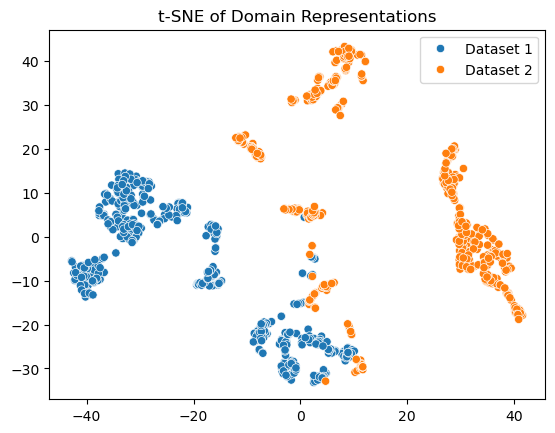

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

reps = torch.cat([rep1, rep2]).numpy()
labels = ['Dataset 1'] * len(rep1) + ['Dataset 2'] * len(rep2)

tsne = TSNE(n_components=2, random_state=42)
reps_2d = tsne.fit_transform(reps)

sns.scatterplot(x=reps_2d[:, 0], y=reps_2d[:, 1], hue=labels)
plt.title("t-SNE of Domain Representations")
plt.show()

In [18]:
# Define your sequence length
SEQ_LEN = 50

def create_classwise_sequences(df, label_value, seq_len=SEQ_LEN):
    df_class = df[df['label'] == label_value]
    data = df_class[feature_cols].values
    X = [data[i:i+seq_len] for i in range(len(data) - seq_len + 1)]
    return torch.tensor(np.array(X), dtype=torch.float32)

In [19]:
with torch.no_grad():
    # Class 0 (benign)
    X1_0 = create_classwise_sequences(df1, label_value=0)
    X2_0 = create_classwise_sequences(df2, label_value=0)
    rep1_0 = encoder(X1_0)
    rep2_0 = encoder(X2_0)

    # Class 1 (attack)
    X1_1 = create_classwise_sequences(df1, label_value=1)
    X2_1 = create_classwise_sequences(df2, label_value=1)
    rep1_1 = encoder(X1_1)
    rep2_1 = encoder(X2_1)


In [20]:
cos_0 = cosine_similarity(rep1_0, rep2_0)
mmd_0 = compute_mmd(rep1_0, rep2_0)

cos_1 = cosine_similarity(rep1_1, rep2_1)
mmd_1 = compute_mmd(rep1_1, rep2_1)

print(f"Class 0 (Benign) - Cosine Similarity: {cos_0:.4f}, MMD: {mmd_0:.4f}")
print(f"Class 1 (Attack) - Cosine Similarity: {cos_1:.4f}, MMD: {mmd_1:.4f}")


Class 0 (Benign) - Cosine Similarity: 0.6583, MMD: 1.9529
Class 1 (Attack) - Cosine Similarity: 0.9567, MMD: 0.5694


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Setup
base_path = "/Users/souba636/Documents/vinnova_project_python/data-traces3-NOMS-2025/Blackhole/20/base/"  # Change to your actual folder
folders = sorted([f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])

# Adjust as needed
feature_cols = ['rank', 'disr', 'diss', 'dior', 'dios', 'diar', 'tots',
                'rank.1', 'disr.1', 'diss.1', 'dior.1', 'dios.1', 'diar.1', 'tots.1']
seq_len = 50

# Load and preprocess one domain
def load_domain_data(folder_path):
    df = pd.read_csv(os.path.join(folder_path, "features_timeseries_60_sec.csv"))
    data = df[feature_cols].values
    X = [data[i:i+seq_len] for i in range(len(data) - seq_len + 1)]
    return torch.tensor(np.array(X), dtype=torch.float32)

# Define encoder
class LSTMEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return h_n[-1]

# MMD computation
def compute_mmd(x, y, gamma=1.0):
    def rbf_kernel(a, b):
        dist = torch.cdist(a, b) ** 2
        return torch.exp(-gamma * dist)
    K_XX = rbf_kernel(x, x)
    K_YY = rbf_kernel(y, y)
    K_XY = rbf_kernel(x, y)
    return (K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()).item()

# Encode all domains
encoder = LSTMEncoder(input_dim=14)
domain_reps = []

print("Encoding domains...")
for folder in tqdm(folders):
    X = load_domain_data(os.path.join(base_path, folder))
    with torch.no_grad():
        rep = encoder(X)
    domain_reps.append(rep)

# Compute pairwise MMD matrix
N = len(domain_reps)
mmd_matrix = np.zeros((N, N))

print("Computing MMD between all domain pairs...")
for i in range(N):
    for j in range(N):
        mmd_matrix[i, j] = compute_mmd(domain_reps[i], domain_reps[j])

# Save as DataFrame
mmd_df = pd.DataFrame(mmd_matrix, index=folders, columns=folders)
mmd_df.to_csv("mmd_matrix.csv")
print("MMD matrix saved as mmd_matrix.csv")


Encoding domains...


100%|██████████| 19/19 [00:00<00:00, 20.63it/s]


Computing MMD between all domain pairs...
MMD matrix saved as mmd_matrix.csv


In [27]:
# Min-max normalization
mmd_min = np.min(mmd_matrix)
mmd_max = np.max(mmd_matrix)

mmd_matrix_norm = (mmd_matrix - mmd_min) / (mmd_max - mmd_min)

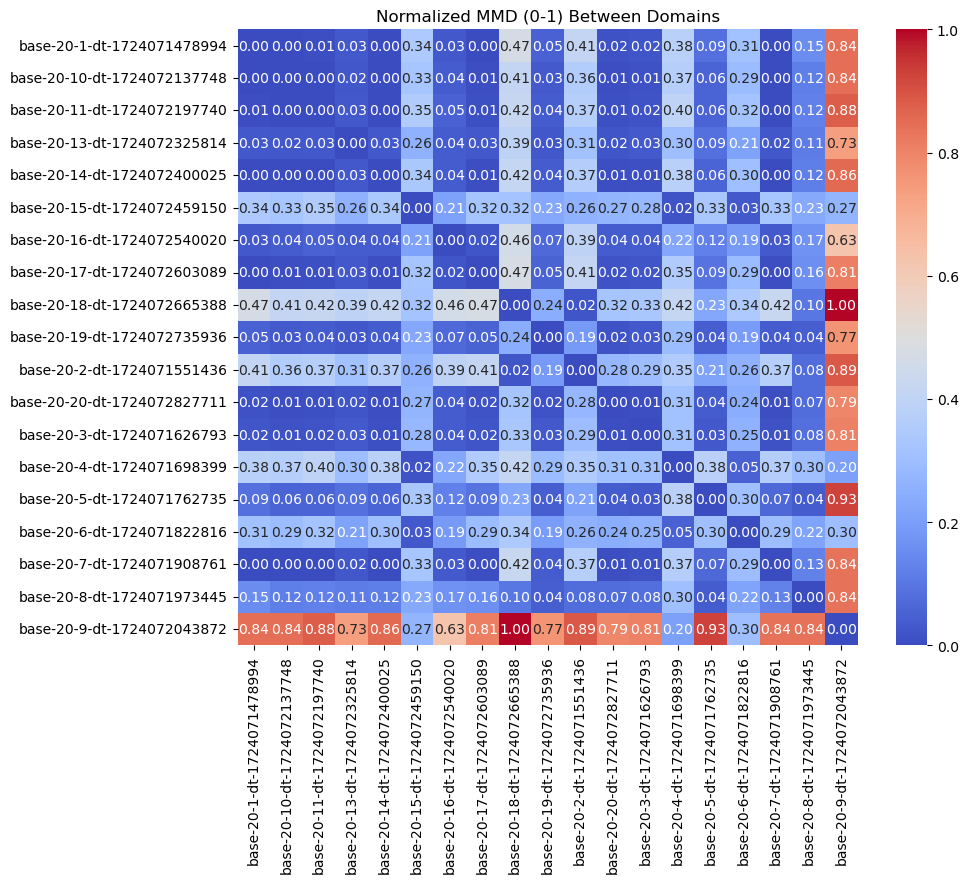

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

mmd_df_norm = pd.DataFrame(mmd_matrix_norm, index=folders, columns=folders)

plt.figure(figsize=(10, 8))
sns.heatmap(mmd_df_norm, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Normalized MMD (0-1) Between Domains")
plt.show()


Loading CSVs: 100%|██████████| 20/20 [00:00<00:00, 104.40it/s]


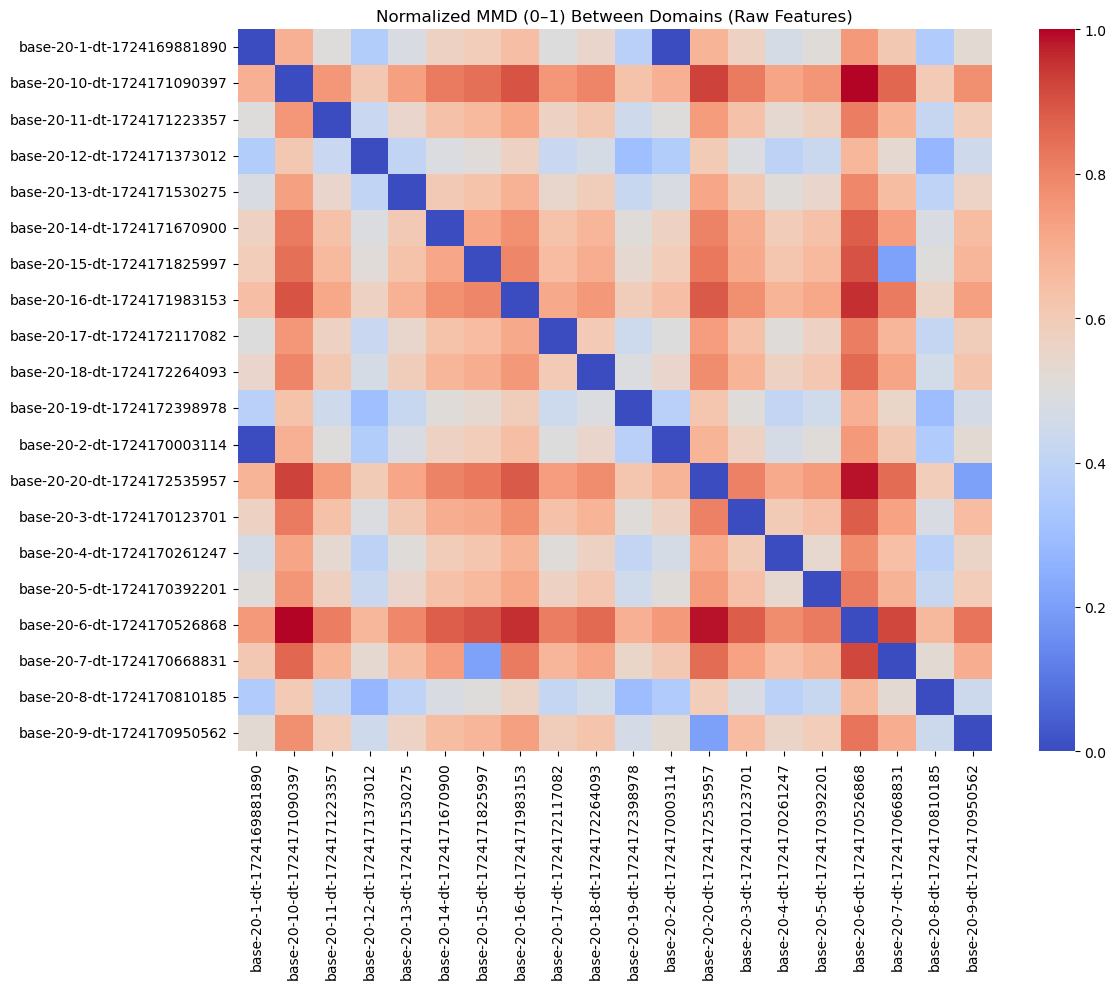

In [36]:
import os
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Path to folder containing all domain subfolders
base_path = "/Users/souba636/Documents/vinnova_project_python/data-traces3-NOMS-2025/disflooding/20/base/"   

# Your 14 feature columns
feature_cols = ['rank', 'disr', 'diss', 'dior', 'dios', 'diar', 'tots',
                'rank.1', 'disr.1', 'diss.1', 'dior.1', 'dios.1', 'diar.1', 'tots.1']

# Function to compute MMD
def compute_mmd(x, y, gamma=1.0):
    def rbf_kernel(a, b):
        dist = torch.cdist(a, b) ** 2
        return torch.exp(-gamma * dist)
    K_XX = rbf_kernel(x, x)
    K_YY = rbf_kernel(y, y)
    K_XY = rbf_kernel(x, y)
    return (K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()).item()

# Load all domain features
folders = sorted([f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])
domain_features = []

for folder in tqdm(folders, desc="Loading CSVs"):
    path = os.path.join(base_path, folder, "features_timeseries_60_sec.csv")
    df = pd.read_csv(path)
    x = torch.tensor(df[feature_cols].values, dtype=torch.float32)
    domain_features.append(x)

# Compute pairwise MMD
N = len(domain_features)
mmd_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        mmd_matrix[i, j] = compute_mmd(domain_features[i], domain_features[j])

# Normalize MMD to [0, 1]
mmd_min = mmd_matrix.min()
mmd_max = mmd_matrix.max()
mmd_matrix_norm = (mmd_matrix - mmd_min) / (mmd_max - mmd_min)

# Save and visualize
mmd_df = pd.DataFrame(mmd_matrix_norm, index=folders, columns=folders)
mmd_df.to_csv("normalized_mmd_matrix.csv")

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(mmd_df, cmap="coolwarm", annot=False, xticklabels=True, yticklabels=True)
plt.title("Normalized MMD (0–1) Between Domains (Raw Features)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("mmd_heatmap.png")
plt.show()


Loading data and preparing sequences...


100%|██████████| 20/20 [00:00<00:00, 87.96it/s]


Encoding domains using LSTM...


100%|██████████| 20/20 [00:01<00:00, 18.54it/s]


Computing MMD (raw and LSTM)...


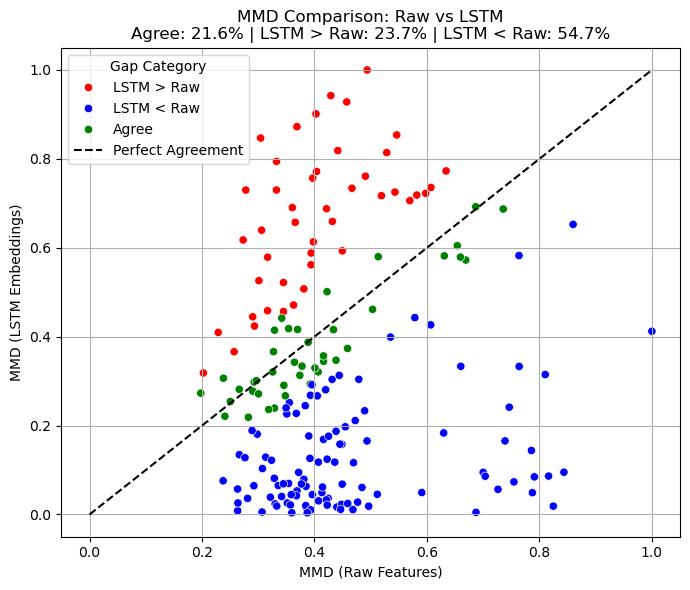

In [40]:
import os
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------
# Config
# -----------------------

base_path = "/Users/souba636/Documents/vinnova_project_python/data-traces3-NOMS-2025/worst_parent/20/oo/"   

feature_cols = ['rank', 'disr', 'diss', 'dior', 'dios', 'diar', 'tots',
                'rank.1', 'disr.1', 'diss.1', 'dior.1', 'dios.1', 'diar.1', 'tots.1']
seq_len = 50
hidden_dim = 64

# -----------------------
# Utilities
# -----------------------
def compute_mmd(x, y, gamma=1.0):
    def rbf_kernel(a, b):
        dist = torch.cdist(a, b) ** 2
        return torch.exp(-gamma * dist)
    return (rbf_kernel(x, x).mean() +
            rbf_kernel(y, y).mean() -
            2 * rbf_kernel(x, y).mean()).item()

class LSTMEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return h_n[-1]  # Final hidden state

def create_sequences(data, seq_len):
    return torch.tensor(np.array([
        data[i:i+seq_len]
        for i in range(len(data) - seq_len + 1)
    ]), dtype=torch.float32)

def normalize(matrix):
    return (matrix - matrix.min()) / (matrix.max() - matrix.min())

# -----------------------
# Load and process domains
# -----------------------
folders = sorted([f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])
domain_raw = []
domain_seq = []

print("Loading data and preparing sequences...")
for folder in tqdm(folders):
    df = pd.read_csv(os.path.join(base_path, folder, "features_timeseries_60_sec.csv"))
    raw_tensor = torch.tensor(df[feature_cols].values, dtype=torch.float32)
    domain_raw.append(raw_tensor)
    domain_seq.append(create_sequences(df[feature_cols].values, seq_len=seq_len))

# -----------------------
# Encode using LSTM
# -----------------------
encoder = LSTMEncoder(input_dim=14, hidden_dim=hidden_dim)
domain_lstm = []

print("Encoding domains using LSTM...")
for seq in tqdm(domain_seq):
    with torch.no_grad():
        rep = encoder(seq)
    domain_lstm.append(rep)

# -----------------------
# Compute pairwise MMD
# -----------------------
N = len(domain_raw)
mmd_raw = np.zeros((N, N))
mmd_lstm = np.zeros((N, N))

print("Computing MMD (raw and LSTM)...")
for i in range(N):
    for j in range(N):
        mmd_raw[i, j] = compute_mmd(domain_raw[i], domain_raw[j])
        mmd_lstm[i, j] = compute_mmd(domain_lstm[i], domain_lstm[j])

# -----------------------
# Normalize
# -----------------------
mmd_raw_norm = normalize(mmd_raw)
mmd_lstm_norm = normalize(mmd_lstm)

# -----------------------
# Scatter Comparison with Colors
# -----------------------
upper_tri_idx = np.triu_indices(N, k=1)
raw_vals = mmd_raw_norm[upper_tri_idx]
lstm_vals = mmd_lstm_norm[upper_tri_idx]

# Classify into color categories
threshold = 0.1
diff = lstm_vals - raw_vals
colors = np.where(np.abs(diff) < threshold, 'Agree',
         np.where(diff > 0, 'LSTM > Raw', 'LSTM < Raw'))

# Count percentages
total = len(colors)
counts = {
    'Agree': np.sum(colors == 'Agree'),
    'LSTM > Raw': np.sum(colors == 'LSTM > Raw'),
    'LSTM < Raw': np.sum(colors == 'LSTM < Raw')
}
percentages = {k: 100 * v / total for k, v in counts.items()}

# Generate label for title
summary = " | ".join([f"{k}: {percentages[k]:.1f}%" for k in ['Agree', 'LSTM > Raw', 'LSTM < Raw']])

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(x=raw_vals, y=lstm_vals, hue=colors,
                palette={'Agree': 'green', 'LSTM > Raw': 'red', 'LSTM < Raw': 'blue'})
plt.xlabel("MMD (Raw Features)")
plt.ylabel("MMD (LSTM Embeddings)")
plt.title(f"MMD Comparison: Raw vs LSTM\n{summary}")
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Agreement')
plt.legend(title="Gap Category")
plt.grid(True)
plt.tight_layout()
plt.show()
